# Focus: Tech, Frequency: Weekly

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
from tqdm import tqdm
import random
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import NearestNeighbors, KNeighborsRegressor
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import lightgbm as lgb

In [2]:
import warnings
warnings.filterwarnings('ignore') 

In [3]:
random.seed(42)
state = random.getstate()
random.setstate(state=state)

In [4]:
global_start_date = pd.Timestamp('2021-01-01')
pd_global_start_date = pd.to_datetime(global_start_date).timestamp()

In [5]:
np.random.seed(42)
np_state = np.random.get_state()
np.random.set_state(np_state)

### Choose a suitable portfolio

In [6]:
focus = 'tech'
pf_name = 'portfolio_33'

In [7]:
# focus dataset
df = pd.read_csv(f'Portfolios/{focus}/{pf_name}.csv')
df.dtypes

Date                 object
Symbol               object
Sector               object
Buy Price           float64
Buy Volume          float64
Sell Price          float64
Sell Volume         float64
Dividends           float64
Stock Shares        float64
Investment Total    float64
Returns             float64
dtype: object

### Randomly induce nan values for 3-7% of the dataset

In [8]:
# randomly induce nan values for 3-7% of the dataset
total_cells = df.size
num_cells_to_replace = np.random.randint(int(total_cells * 0.03), int(total_cells * 0.07) + 1)
indices_to_replace = np.random.choice(np.arange(total_cells), size=num_cells_to_replace, replace=False)
row_indices, col_indices = np.unravel_index(indices_to_replace, df.shape)

for idx in range(len(row_indices)):
    df.iat[row_indices[idx], col_indices[idx]] = np.nan

nan_count = df.isna().sum()

print(f'Number of entries in Dataframe: {df.size}')
print(nan_count)

Number of entries in Dataframe: 1694
Date                11
Symbol               8
Sector               9
Buy Price            9
Buy Volume           7
Sell Price           8
Sell Volume          5
Dividends           10
Stock Shares        12
Investment Total    12
Returns             10
dtype: int64


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Symbol,Sector,Buy Price,Buy Volume,Sell Price,Sell Volume,Dividends,Stock Shares,Investment Total,Returns
0,2021-01-04,INTC,tech,50.221855,1.946240,0.0,0.0,0.0,1.946240,97.743798,-1.074046
1,2021-01-11,PEP,consumer_goods,143.747568,2.286459,0.0,0.0,0.0,2.286459,426.416687,-1.224539
2,2021-01-19,NaN,tech,127.275124,2.917816,0.0,0.0,NaN,NaN,797.782134,12.879153
3,2021-01-25,IBM,tech,113.397612,4.601357,0.0,0.0,0.0,4.601357,1319.565062,47.498399
4,2021-02-01,ORCL,tech,61.139181,3.922304,NaN,0.0,0.0,3.922304,1559.371544,27.072608


### NaN handling

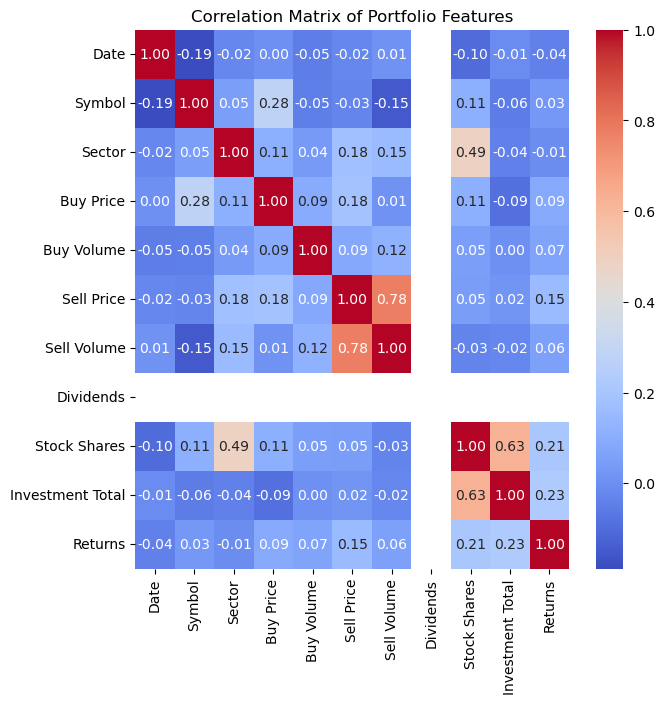

In [10]:
# correlations
df_copy = df.copy()
categorical = ['Symbol', 'Sector']

def corr_heatmap(df_sample):
    categorical = ['Symbol', 'Sector']
    label_encoders = {}
    for column in categorical:
        label_encoder = LabelEncoder()
        valid_data = df_sample[column][df_sample[column].notna()]
        encoded_data = label_encoder.fit_transform(valid_data.astype(str))
        df_sample.loc[df_sample[column].notna(), column] = encoded_data
        label_encoders[column] = label_encoder
    correlation_matrix = df_sample.corr()
    return correlation_matrix, label_encoders

correlation_matrix, label_encoders = corr_heatmap(df_copy)

# heatmap
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Portfolio Features')
plt.show()

### Market information

In [11]:
stocks = {
    'tech': ['AAPL', 'MSFT', 'GOOGL', 'META', 'INTC', 'NVDA', 'AMD', 'ORCL', 'IBM', 'TSLA'],
    'consumer_goods': ['AMZN', 'PG', 'KO', 'PEP', 'NKE', 'F', 'GE', 'MMM', 'EL', 'BUD'],
    'healthcare': ['PFE', 'JNJ', 'MRK', 'ABBV', 'LLY', 'GILD', 'BMY', 'AMGN', 'REGN', 'MDT'],
    'finance': ['JPM', 'BAC', 'WFC', 'C', 'GS', 'MS', 'AXP', 'V', 'BRK-B', 'SCHW']
}

all_symbols = []
for sector, symbols in stocks.items():
    for symbol in symbols:
        all_symbols.append(symbol)

print(len(all_symbols))

40


In [12]:
all_sectors = list(stocks.keys())
print(all_sectors)

['tech', 'consumer_goods', 'healthcare', 'finance']


In [13]:
# handle nan values based on correlation

# forward fill columns for time related data
ffill_cols = ['Date', 'Buy Price', 'Sell Price', 'Dividends', 'Investment Total', 'Returns']
for col in ffill_cols:
    if df_copy[col].isna().any():
        df_copy[col].fillna(method='ffill', inplace=True)

# median/mean/mode fill columns for no clear correlations
if df_copy['Buy Volume'].isna().any():
    df_copy['Buy Volume'].fillna(df_copy['Buy Volume'].mean(), inplace=True)
if df_copy['Sell Volume'].isna().any():
    df_copy['Sell Volume'].fillna(df_copy['Sell Volume'].mean(), inplace=True)
if df_copy['Symbol'].isna().any():
    df_copy['Symbol'].fillna(df_copy['Symbol'].dropna().mode()[0], inplace=True)
if df_copy['Sector'].isna().any():
    df_copy['Sector'].fillna(df_copy['Sector'].dropna().mode()[0], inplace=True)

# regression imputation for correlated features
if df_copy['Stock Shares'].isna().any():
    train_data = df_copy[df_copy['Stock Shares'].notna()]
    test_data = df_copy[df_copy['Stock Shares'].isna()]

    X_train = train_data[['Symbol', 'Sector', 'Investment Total']]
    y_train = train_data['Stock Shares']

    linreg = LinearRegression().fit(X=X_train, y=y_train)
    X_test = test_data[['Symbol', 'Sector', 'Investment Total']]
    stock_preds = linreg.predict(X=X_test)
    df_copy.loc[df_copy['Stock Shares'].isna(), 'Stock Shares'] = stock_preds

nan_count = df_copy.isna().sum()
print(nan_count)

Date                0
Symbol              0
Sector              0
Buy Price           0
Buy Volume          0
Sell Price          0
Sell Volume         0
Dividends           0
Stock Shares        0
Investment Total    0
Returns             0
dtype: int64


In [14]:
for column in categorical:
    df_copy[column] = pd.to_numeric(df_copy[column], errors='coerce')
    df_copy[column] = label_encoders[column].inverse_transform(df_copy[column])
df_copy.head()

,Date,Symbol,Sector,Buy Price,Buy Volume,Sell Price,Sell Volume,Dividends,Stock Shares,Investment Total,Returns
0,2021-01-04,INTC,tech,50.221855,1.946240,0.0,0.0,0.0,1.946240,97.743798,-1.074046
1,2021-01-11,PEP,consumer_goods,143.747568,2.286459,0.0,0.0,0.0,2.286459,426.416687,-1.224539
2,2021-01-19,AMD,tech,127.275124,2.917816,0.0,0.0,0.0,3.437945,797.782134,12.879153
3,2021-01-25,IBM,tech,113.397612,4.601357,0.0,0.0,0.0,4.601357,1319.565062,47.498399
4,2021-02-01,ORCL,tech,61.139181,3.922304,0.0,0.0,0.0,3.922304,1559.371544,27.072608


### Feature Engineering

In [15]:
# feature engineering
df_copy['Rolling Returns'] = df_copy['Returns'].rolling(window=90, min_periods=1).mean()

def preprocess_df(df_sample, all_symbols, all_sectors):
    num_features = ['Buy Price', 'Buy Volume', 'Sell Price', 'Sell Volume', 'Dividends', 'Stock Shares', 'Investment Total', 'Rolling Returns']
    cat_features = ['Symbol', 'Sector']

    df_sample['Symbol'] = pd.Categorical(df_sample['Symbol'], categories=all_symbols)
    df_sample['Sector'] = pd.Categorical(df_sample['Sector'], categories=all_sectors)
    df_prepped = pd.get_dummies(df_sample, columns=cat_features)

    print(f'Number of columns after one-hot should be 12 - 2 + 40 + 4 = 54: {len(df_prepped.columns)}')

    scaler = MinMaxScaler()
    df_prepped[num_features] = scaler.fit_transform(df_prepped[num_features])
    return df_prepped

df_copy_prepped = preprocess_df(df_copy, all_symbols, all_sectors)

Number of columns after one-hot should be 12 - 2 + 40 + 4 = 54: 54


## Baseline 1: Projecting self's average growth rate in past to quarter to next quarter

In [16]:
# Baseline 1: project slope of this portfolio itself to the next 90 days

def find_nearest_date(df, target_date):
    if df.empty or df['Date'].isna().any():
        return None
    # find the nearest date to the target_date in the df
    nearest_date = df.iloc[(df['Date'] - target_date).abs().argsort()[:1]]
    return nearest_date['Date'].item()

def self_projection(df_original, window=90, forecast_days=90):
    # slope of returns over the window
    df = df_original.copy()
    df['Days'] = (df['Date'] - df['Date'].iloc[0]).dt.days
    targets = []
    preds = []

    start_date = df['Date'].iloc[0]
    max_date = df['Date'].iloc[-1]

    start_date_idx = 0
    
    while start_date + pd.Timedelta(days=window + forecast_days) <= max_date:
        end_date = start_date + pd.Timedelta(days=window)
        # date for returns
        target_date = end_date + pd.Timedelta(days=forecast_days)
        predict_date = find_nearest_date(df, target_date)

        window_df = df[(df['Date'] >= start_date) & (df['Date'] < end_date)]
        predict_day_df = df[df['Date'] == predict_date].iloc[0:1]

        if not window_df.empty:
            try: # when linear regression can be done
                coef = np.polyfit(window_df['Days'], window_df['Returns'], 1)[0]
                pred_return = window_df['Returns'].iloc[-1] + coef * forecast_days
                preds.append(pred_return)
                
            except: # when linear regression cannot be done (eg: only one sample)
                preds.append(window_df['Returns'].iloc[-1])
            
            actual_return = predict_day_df['Returns'].iloc[0]
            targets.append(actual_return)

        # next window
        start_date_idx += 1
        start_date = df['Date'].iloc[start_date_idx]

    return preds, targets

predicted_returns, actual_returns = self_projection(df_copy_prepped.loc[df_copy_prepped['Date'] <= df_copy_prepped['Date'].iloc[-1]])
base1_rmse = np.sqrt(mean_squared_error(actual_returns, predicted_returns))
print(f'Baseline 1 Average RMSE: {base1_rmse} for {len(predicted_returns)} number of predictions')

Baseline 1 Average RMSE: 4173.794808777216 for 127 number of predictions


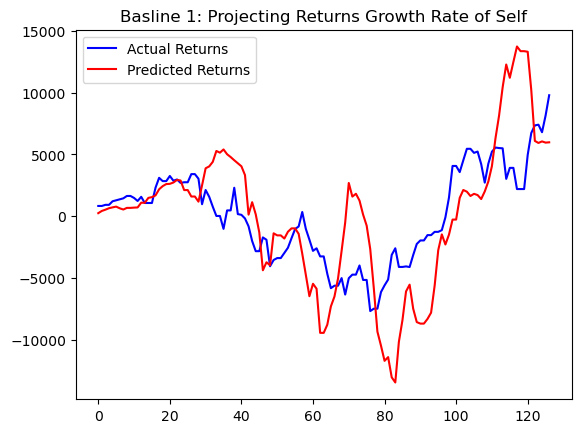

In [17]:
# plot predictions
plt.figure()
x = np.arange(len(actual_returns))
plt.plot(x, actual_returns, label='Actual Returns', color='b')
plt.plot(x, predicted_returns, label='Predicted Returns', color='r')
plt.title("Basline 1: Projecting Returns Growth Rate of Self")
plt.legend()
plt.show()

## Baseline 2: K-NN Regression

In [18]:
# Baseline 2: KNN

df_copy2 = df.copy()
df_copy2.isna().sum()

Date                11
Symbol               8
Sector               9
Buy Price            9
Buy Volume           7
Sell Price           8
Sell Volume          5
Dividends           10
Stock Shares        12
Investment Total    12
Returns             10
dtype: int64

In [19]:
stats_df = pd.read_csv('Portfolio_stats.csv')
stats_df.head()

,Porfolio Index,Frequency,Sector,Buy Price,Buy Volume,Sell Price,Sell Volume,Dividends,Total Investment
0,portfolio_22,87,2.288462,128.641368,5.771953,23.115573,0.460734,0.0,9704.338687
1,portfolio_103,1,2.122449,149.805409,0.490333,32.517791,0.117014,0.0,43401.142746
2,portfolio_35,7,3.074503,142.825275,2.446161,33.793606,0.592522,0.0,38177.148732
3,portfolio_114,29,2.155405,124.703375,8.744467,15.141586,1.323800,0.0,32995.396311
4,portfolio_100,91,2.083333,133.687566,6.906413,0.000000,0.000000,0.0,9715.675024


In [20]:
features_2d = ['Frequency', 'Sector']
stats_df_2d = stats_df[features_2d]
np_stats_2d = np.array(stats_df_2d)

Choose KNN based on Frequency and Sector

In [21]:
# read portfolio into pd df
def read_portfolio(portfolio_index):
    base_dir = 'Portfolios'
    for sector in os.listdir(base_dir):
        filepath = os.path.join(base_dir, sector, f'{portfolio_index}.csv')
        if os.path.exists(filepath):
            return pd.read_csv(filepath)

# fill nan with knn support
def knn_handle_nan(df_sample, neighbor_dfs):
    for col in df_sample.columns:
        if df_sample[col].isna().any():
            missing_idxs = df_sample[df_sample[col].isna()].index
            
            for idx in missing_idxs:
                neighbor_vals = []
                
                for n_df in neighbor_dfs:
                    if idx < len(n_df) and pd.notna(n_df[col].iloc[idx]):
                        neighbor_vals.append(n_df[col].iloc[idx])
                
                if neighbor_vals:
                    # mean for numeric
                    if pd.api.types.is_numeric_dtype(df_sample[col]):
                        filler = np.mean(neighbor_vals)
                    # mode for object
                    else:
                        filler = pd.Series(neighbor_vals).dropna().mode()[0]

                    df_sample[col].iloc[idx] = filler
                
    return df_sample

# data prep
def get_X_y(dfs, window=90, forecast_days=90, window_size=None): # list of dfs
    global pd_global_start_date

    windows = []
    y = []

    min_window_len = float('inf')
    if window_size is not None:
        min_window_len = window_size

    for df in dfs:
        start_date = df['Date'].iloc[0]
        max_date = df['Date'].iloc[-1]
        start_date_idx = 0

        while start_date + pd.Timedelta(days=window + forecast_days) <= max_date:
            end_date = start_date + pd.Timedelta(days=window)
            # date for returns
            target_date = end_date + pd.Timedelta(days=forecast_days)
            predict_date = find_nearest_date(df, target_date)
            
            window_df = df[(df['Date'] >= start_date) & (df['Date'] < end_date)]
            predict_day_df = df[df['Date'] == predict_date].iloc[0:1]
            if not window_df.empty:
                if window_size is None:
                    if min_window_len > len(window_df):
                        min_window_len = len(window_df)
                    # POSIX time encoding for KNN numpy calculations
                    window_df['Date'] = (window_df['Date'].view(int)//10**9 - pd_global_start_date)//86400
                    # add to dataset
                    windows.append(np.array(window_df, dtype=np.float32)) # later to handle variable window sizes
                    y.append(predict_day_df['Returns'].iloc[0])
                else:
                    #test data
                    if len(window_df) < min_window_len: # pad for missing values
                        diff = min_window_len - len(window_df)
                        # padding remaining rows
                        pad_df = pd.DataFrame(np.nan, index=range(diff), columns=window_df.columns)
                        padded_df = pd.concat([window_df, pad_df], ignore_index=True)
                        padded_df.ffill(inplace=True) # can be improved
                        # POSIX time encoding for KNN numpy calculations
                        padded_df['Date'] = (padded_df['Date'].view(int)//10**9 - pd_global_start_date)//86400
                        # add to dataset
                        y.append(predict_day_df['Returns'].iloc[0])
                        windows.append(np.array(padded_df, dtype=np.float32))
                    else:
                        # POSIX time encoding for KNN numpy calculations
                        window_df['Date'] = (window_df['Date'].view(int)//10**9 - pd_global_start_date)//86400
                        # add to dataset
                        y.append(predict_day_df['Returns'].iloc[0])
                        windows.append(np.array(window_df, dtype=np.float32))

            # next window
            start_date_idx += 1
            start_date = df['Date'].iloc[start_date_idx]
    X = [window[:min_window_len, :].reshape(-1) for window in windows] # get same window length
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32), min_window_len

# use knn regression
def knn_projection(df_original, original_nb_dfs, window=90, forecast_days=90):
    df = df_original.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Days'] = (df['Date'] - df['Date'].iloc[0]).dt.days
    target_dfs = [df]
    nb_dfs = original_nb_dfs.copy()
    for nb_df in nb_dfs:
        nb_df['Date'] = pd.to_datetime(nb_df['Date'])
        nb_df['Days'] = (nb_df['Date'] - nb_df['Date'].iloc[0]).dt.days
    
    X_train, y_train, min_window_len = get_X_y(nb_dfs, window=window, forecast_days=forecast_days)
    X_test, y_test, _ = get_X_y(target_dfs, window=window, forecast_days=forecast_days, window_size=min_window_len)

    # KNN Regression
    k_s = [5, 10, 15]
    best_model = {'K': 0, 'model': None, 'rmse': float('inf'), 'y_preds': None, 'y_test': y_test}
    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for k in k_s:
        for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
            x_train_f, x_val = X_train[train_idx], X_train[val_idx]
            y_train_f, y_val = y_train[train_idx], y_train[val_idx]

            knn_reg = KNeighborsRegressor(n_neighbors=k)
            knn_reg.fit(X=x_train_f, y=y_train_f)

            val_pred = knn_reg.predict(x_val)
            fold_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

            if fold_rmse < best_model['rmse']:
                best_model['rmse'] = fold_rmse
                best_model['model'] = knn_reg
                best_model['K'] = k
                
    y_pred = best_model['model'].predict(X=X_test)
    best_model['y_preds'] = y_pred
    knn_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    return best_model, knn_rmse

In [22]:
knn_ks = [5, 10, 15]

# get knn for target portfolio from the stats df
neighbors = NearestNeighbors(n_neighbors=max(knn_ks)+1, metric='euclidean') # as self will get included too
neighbors.fit(np_stats_2d)

test_idx = stats_df[stats_df['Porfolio Index'] == pf_name].index[0]
pf_2d = np_stats_2d[test_idx].reshape(-1, 1).T
distances, indices = neighbors.kneighbors(pf_2d)
neighbor_idxs = np.delete(indices[0], np.where(indices[0]==test_idx)) # remove self from knn


best_knn_model = {'rmse': float('inf')}
for k in knn_ks:
    # knn
    k_nb_idxs = neighbor_idxs[:k]
    neighbor_names = stats_df.iloc[k_nb_idxs]['Porfolio Index']
    
    neighbor_dfs = []
    for name in neighbor_names:
        neighbor_df = read_portfolio(name)
        neighbor_dfs.append(neighbor_df)

    # fill nan values using knn imputations
    df_copy2 = knn_handle_nan(df_copy2, neighbor_dfs)

    neighbor_dfs.append(df_copy2)

    # feature engineering
    for n_df in neighbor_dfs:
        n_df['Rolling Returns'] = n_df['Returns'].rolling(window=90, min_periods=1).mean()
    
    # preprocess all the data together
    df_lengths = [len(n_df) for n_df in neighbor_dfs]
    stacked_df = pd.concat(neighbor_dfs, ignore_index=True, join='inner')
    stacked_df_prepped = preprocess_df(stacked_df, all_symbols, all_sectors)

    # retrieve individually preprocessed dfs
    start = 0
    prepped_dfs = []
    for length in df_lengths:
        end = start + length
        prepped_dfs.append(stacked_df_prepped.iloc[start:end])
        start = end
    df_copy2_prepped = prepped_dfs.pop()
    
    knn_model, knn_rmse = knn_projection(df_copy2_prepped, prepped_dfs)
    if knn_rmse < best_knn_model['rmse']:
        best_knn_model = knn_model
        best_knn_model['rmse'] = knn_rmse
        best_knn_model['portfolios'] = k

base2_rmse = best_knn_model['rmse']
knn_len = len(best_knn_model['y_preds'])
print(f'Baseline 2 Average RMSE: {base2_rmse} for {knn_len} number of predictions')
print("best_model[portfolios] =", best_knn_model['portfolios'])
print("best_model[K] =", best_knn_model['K'])

Number of columns after one-hot should be 12 - 2 + 40 + 4 = 54: 54
Number of columns after one-hot should be 12 - 2 + 40 + 4 = 54: 54
Number of columns after one-hot should be 12 - 2 + 40 + 4 = 54: 54
Baseline 2 Average RMSE: 1396.4920654296875 for 128 number of predictions
best_model[portfolios] = 5
best_model[K] = 5


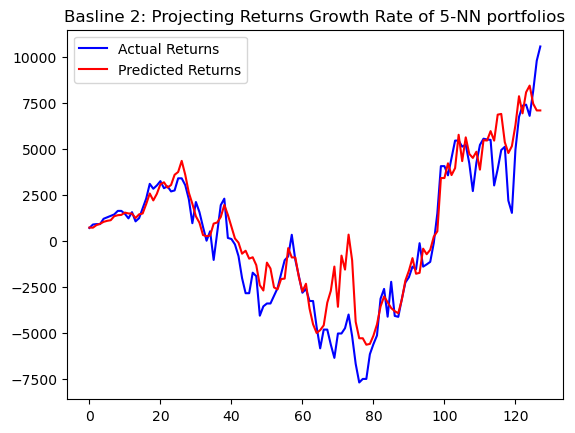

In [23]:
# plot predictions
plt.figure()
x = np.arange(len(best_knn_model['y_test']))
plt.plot(x, best_knn_model['y_test'], label='Actual Returns', color='b')
plt.plot(x, best_knn_model['y_preds'], label='Predicted Returns', color='r')
plt.title(f"Basline 2: Projecting Returns Growth Rate of {best_knn_model['portfolios']}-NN portfolios")
plt.legend()
plt.show()

## Method 1: LSTM

In [24]:
# Method 1: LSTM

class Forecast_LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, dropout_rate, output_dim=1):
        super(Forecast_LSTM, self).__init__()
        # 2-layer LSTM with dropout
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, 
                            batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        self.batch_norm = nn.BatchNorm1d(hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # forward pass
        lstm_out, (hidden, cell) = self.lstm(x)
        lstm_out = lstm_out[:, -1, :]
        # batch normalization and dropout
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        # final output layer
        output = self.fc(lstm_out)
        return output

In [25]:
def restore_2d_array(X, num_rows):
    num_ele = X.size
    num_cols = num_ele // num_rows

    original_2d_array = X.reshape(num_rows, num_cols)
    return original_2d_array

def LSTM_preprocess(Xs, ys):
    features = np.stack(Xs, axis=0) # 3D data for LSTM
    targets = np.array(ys)

    # to tensors
    features = torch.tensor(features, dtype=torch.float32)
    targets = torch.tensor(targets, dtype=torch.float32).view(-1, 1)

    return features, targets

def LSTM_train_and_eval(X, y, splits=5):
    kf = KFold(n_splits=splits)
    best_lstm_loss = float('inf')

    train_losses = []
    val_losses = []
    min_epoch = 500
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        print(f"Training fold {fold+1}/{splits}")
        train_features, val_features = X[train_idx], X[val_idx]
        train_targets, val_targets = y[train_idx], y[val_idx]

        train_data = TensorDataset(train_features, train_targets)
        val_data = TensorDataset(val_features, val_targets)

        batch_size = max(32, len(train_data)//10)
        
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
        
        model = Forecast_LSTM(input_dim=X.size(2), hidden_dim=128, dropout_rate=0.2)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0.01)

        fold_train_losses = []
        fold_val_losses = []

        best_loss = float('inf')
        patience, trials = 20, 0

        pbar = tqdm(range(500), desc="Training Progress")

        for epoch in pbar:  # max 500 epochs
            model.train()
            for inputs, labels in train_loader:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
            fold_train_losses.append(np.sqrt(loss.item())) #RMSE

            # val
            model.eval()
            with torch.no_grad():
                val_loss = 0
                for inputs, labels in val_loader:
                    outputs = model(inputs)
                    val_loss += criterion(outputs, labels).item()
                val_loss /= len(val_loader)
                sqrt_val_loss = np.sqrt(val_loss)
                fold_val_losses.append(sqrt_val_loss)

            pbar.set_description(f"Epoch {epoch+1} RMSE Loss: {sqrt_val_loss:.4f}")

            # if epoch%1000==0:
            #     tqdm.write(f"Epoch {epoch+1}, Validation RMSE Loss: {sqrt_val_loss}")

            # early stopping
            if val_loss < best_loss:
                best_loss = val_loss
                trials = 0
                if best_loss < best_lstm_loss:
                    torch.save(model.state_dict(), 'best_model.pth')
            else:
                trials += 1
                if trials >= patience:
                    print("Early stopping...")
                    if min_epoch > epoch + 1:
                        min_epoch = epoch + 1
                    break
        train_losses.append(fold_train_losses)
        val_losses.append(fold_val_losses)

    train_losses = np.array([x[:min_epoch] for x in train_losses])
    val_losses = np.array([x[:min_epoch] for x in val_losses])

    # for loss plots
    train_losses = np.mean(train_losses, axis=0)
    val_losses = np.mean(val_losses, axis=0)

    # # load the best model
    model.load_state_dict(torch.load('best_model.pth'))
    return model, train_losses, val_losses

def plot_loss_curve(train_losses, val_losses):
    x = np.arange(len(train_losses))
    plt.figure()
    plt.plot(x, train_losses, label='Training Loss', color='b')
    plt.plot(x, val_losses, label='Validation Loss', color='r')
    plt.title("LSTM RMSE plots")
    plt.legend()
    plt.show()

def LSTM_predict(model, X):
    model.eval()
    with torch.no_grad():
        predictions = model(X)
    return predictions.numpy()

def LSTM_Projection(df_original, original_nb_dfs, window=90, forecast_days=90):
    df = df_original.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Days'] = (df['Date'] - df['Date'].iloc[0]).dt.days
    target_dfs = [df]
    nb_dfs = original_nb_dfs.copy()
    for nb_df in nb_dfs:
        nb_df['Date'] = pd.to_datetime(nb_df['Date'])
        nb_df['Days'] = (nb_df['Date'] - nb_df['Date'].iloc[0]).dt.days
    
    X_train, y_train, min_window_len = get_X_y(nb_dfs, window=window, forecast_days=forecast_days)
    X_test, y_test, _ = get_X_y(target_dfs, window=window, forecast_days=forecast_days, window_size=min_window_len)

    X_train_2d = [restore_2d_array(X, min_window_len) for X in X_train]
    X_test_2d = [restore_2d_array(X, min_window_len) for X in X_test]

    X_train_lstm, y_train_lstm = LSTM_preprocess(X_train_2d, y_train)
    X_test_lstm, y_test_lstm = LSTM_preprocess(X_test_2d, y_test)

    # training
    model, train_losses, val_losses = LSTM_train_and_eval(X_train_lstm, y_train_lstm)
    # print(len(train_losses), len(val_losses))
    plot_loss_curve(train_losses, val_losses)

    # predict
    y_pred_lstm = LSTM_predict(model, X_test_lstm)
    y_test_lstm = y_test_lstm.numpy()

    test_rmse = np.sqrt(mean_squared_error(y_test_lstm, y_pred_lstm))   

    return model, test_rmse, y_pred_lstm, y_test_lstm

Number of columns after one-hot should be 12 - 2 + 40 + 4 = 54: 54
Training fold 1/5


Epoch 57 RMSE Loss: 3820.0124:  11%|█         | 56/500 [00:08<01:10,  6.27it/s]


Early stopping...
Training fold 2/5


Epoch 56 RMSE Loss: 3143.8871:  11%|█         | 55/500 [00:08<01:07,  6.55it/s]


Early stopping...
Training fold 3/5


Epoch 80 RMSE Loss: 2526.8788:  16%|█▌        | 79/500 [00:12<01:06,  6.30it/s]


Early stopping...
Training fold 4/5


Epoch 80 RMSE Loss: 3565.4310:  16%|█▌        | 79/500 [00:12<01:05,  6.40it/s]


Early stopping...
Training fold 5/5


Epoch 46 RMSE Loss: 2870.5196:   9%|▉         | 45/500 [00:07<01:11,  6.32it/s]


Early stopping...


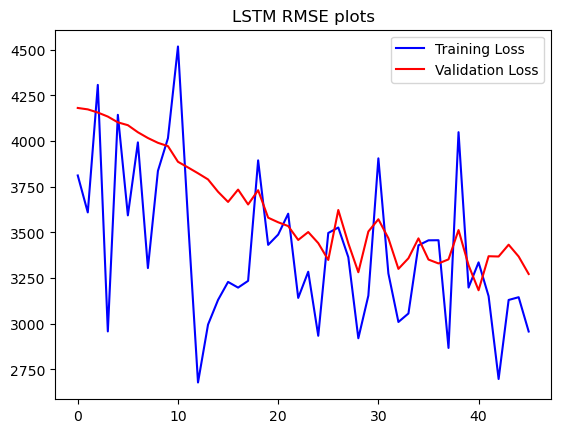

Method 1 Average RMSE: 2975.62255859375 for LSTM


In [26]:
k = best_knn_model['portfolios']

# get knn for target portfolio from the stats df
neighbors = NearestNeighbors(n_neighbors=k+1, metric='euclidean') # as self will get included too
neighbors.fit(np_stats_2d)

test_idx = stats_df[stats_df['Porfolio Index'] == pf_name].index[0]
pf_2d = np_stats_2d[test_idx].reshape(-1, 1).T
distances, indices = neighbors.kneighbors(pf_2d)
neighbor_idxs = np.delete(indices[0], np.where(indices[0]==test_idx)) # remove self from knn

# knn
k_nb_idxs = neighbor_idxs[:k]
neighbor_names = stats_df.iloc[k_nb_idxs]['Porfolio Index']

neighbor_dfs = []
for name in neighbor_names:
    neighbor_df = read_portfolio(name)
    neighbor_dfs.append(neighbor_df)

# fill nan values using knn imputations
df_copy2 = knn_handle_nan(df_copy2, neighbor_dfs)

neighbor_dfs.append(df_copy2)

# feature engineering
for n_df in neighbor_dfs:
    n_df['Rolling Returns'] = n_df['Returns'].rolling(window=90, min_periods=1).mean()

# preprocess all the data together
df_lengths = [len(n_df) for n_df in neighbor_dfs]
stacked_df = pd.concat(neighbor_dfs, ignore_index=True, join='inner')
stacked_df_prepped = preprocess_df(stacked_df, all_symbols, all_sectors)

# retrieve individually preprocessed dfs
start = 0
prepped_dfs = []
for length in df_lengths:
    end = start + length
    prepped_dfs.append(stacked_df_prepped.iloc[start:end])
    start = end
df_copy2_prepped = prepped_dfs.pop()

# LSTM
lstm_model, test_rmse, y_pred_lstm, y_test_lstm = LSTM_Projection(df_copy2_prepped, prepped_dfs)

print(f'Method 1 Average RMSE: {test_rmse} for LSTM')

LSTM hyperparameters can be tuned much more extensively, but not done here due to lack of computational resources.

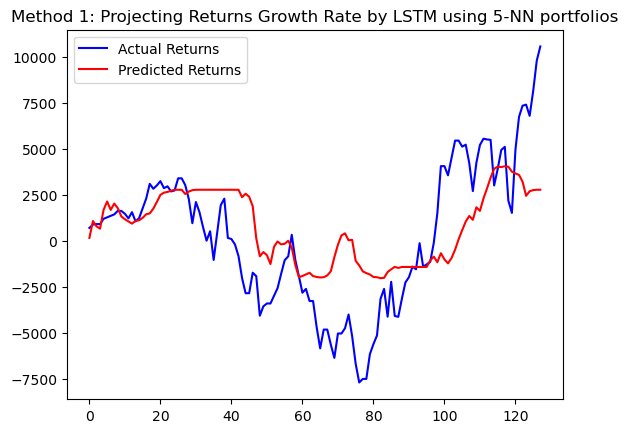

In [27]:
# plot predictions
plt.figure()
x = np.arange(len(y_test_lstm))
plt.plot(x, y_test_lstm, label='Actual Returns', color='b')
plt.plot(x, y_pred_lstm, label='Predicted Returns', color='r')
plt.title(f"Method 1: Projecting Returns Growth Rate by LSTM using {best_knn_model['portfolios']}-NN portfolios")
plt.legend()
plt.show()

## Method 2: LGBM

In [28]:
# Method 2: LGBM 

def LGBM_Projection(df_original, original_nb_dfs, window=90, forecast_days=90):
    df = df_original.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df['Days'] = (df['Date'] - df['Date'].iloc[0]).dt.days
    target_dfs = [df]
    nb_dfs = original_nb_dfs.copy()
    for nb_df in nb_dfs:
        nb_df['Date'] = pd.to_datetime(nb_df['Date'])
        nb_df['Days'] = (nb_df['Date'] - nb_df['Date'].iloc[0]).dt.days
    
    X_train, y_train, min_window_len = get_X_y(nb_dfs, window=window, forecast_days=forecast_days)
    X_test, y_test, _ = get_X_y(target_dfs, window=window, forecast_days=forecast_days, window_size=min_window_len)

    n_splits = 5 
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    best_lgb_rmse = float('inf')
    best_lgb_model = None

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
        x_train_f, x_val = X_train[train_idx], X_train[val_idx]
        y_train_f, y_val = y_train[train_idx], y_train[val_idx]

        # train lgbm
        lgb_reg = lgb.LGBMRegressor(
            boosting_type='dart',
            num_leaves=100,
            max_depth=8,
            learning_rate=0.1,
            n_estimators=1000,
            random_state=42,
        )
        lgb_reg.fit(
            x_train_f, y_train_f, eval_set=[(x_val, y_val)], eval_metric='rmse'
        )

        val_pred = lgb_reg.predict(x_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

        if val_rmse < best_lgb_rmse:
            best_lgb_rmse = val_rmse
            best_lgb_model = lgb_reg
        
    y_pred = best_lgb_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return best_lgb_model, test_rmse, y_pred, y_test

In [29]:
# LGBM

lgbm_model, test_lgbm_rmse, y_pred_lgbm, y_test_lgbm = LGBM_Projection(df_copy2_prepped, prepped_dfs)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 17432
[LightGBM] [Info] Number of data points in the train set: 507, number of used features: 288
[LightGBM] [Info] Start training from score 1046.303521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive ga

In [30]:
print(f'Method 2 Average RMSE: {test_lgbm_rmse} for LGBM')

Method 2 Average RMSE: 1142.222890896805 for LGBM


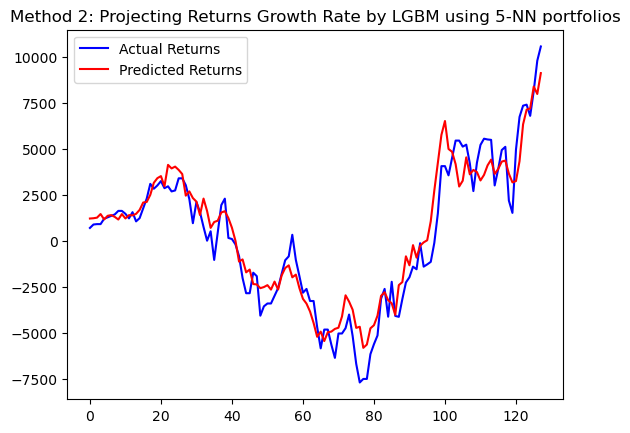

In [31]:
# plot predictions
plt.figure()
x = np.arange(len(y_test_lgbm))
plt.plot(x, y_test_lgbm, label='Actual Returns', color='b')
plt.plot(x, y_pred_lgbm, label='Predicted Returns', color='r')
plt.title(f"Method 2: Projecting Returns Growth Rate by LGBM using {best_knn_model['portfolios']}-NN portfolios")
plt.legend()
plt.show()

### Feaature importances

In [32]:
feature_names = df_copy2_prepped.columns
gain_importances = lgbm_model.booster_.feature_importance(importance_type='gain')

# convert flattened array for averages of columns
gain_importances = gain_importances.reshape(len(gain_importances)//(len(feature_names)+1), len(feature_names)+1)
# remove the column 'Days' we used to mark gaps as 'Date' column is there
gain_importances = np.mean(gain_importances, axis=0)[:-1]

feature_gains = pd.DataFrame({'Feature': feature_names, 'Gain Importance': gain_importances})
feature_gains_sorted = feature_gains.sort_values(by='Gain Importance', ascending=False).reset_index(drop=True)
feature_gains_sorted.head(len(feature_gains_sorted))

,Feature,Gain Importance
0,Date,9.312430e+09
1,Investment Total,2.945188e+09
2,Returns,1.586095e+09
3,Rolling Returns,1.150300e+09
4,Buy Volume,1.560346e+08
5,Stock Shares,1.156601e+08
6,Buy Price,7.372798e+07
7,Sell Volume,2.214410e+06
8,Sell Price,1.470769e+06
9,Symbol_MSFT,1.241105e+06


In [33]:
split_importances = lgbm_model.booster_.feature_importance(importance_type='split')

split_importances = split_importances.reshape(len(split_importances)//(len(feature_names)+1), len(feature_names)+1)
split_importances = np.mean(split_importances, axis=0)[:-1]

feature_splits = pd.DataFrame({'Feature': feature_names, 'Split Importance': split_importances})
feature_splits_sorted = feature_splits.sort_values(by='Split Importance', ascending=False).reset_index(drop=True)
feature_splits_sorted.head(len(feature_splits_sorted))

,Feature,Split Importance
0,Returns,386.750000
1,Date,274.250000
2,Rolling Returns,253.916667
3,Investment Total,207.583333
4,Buy Volume,128.250000
5,Stock Shares,125.416667
6,Buy Price,104.500000
7,Sell Price,4.416667
8,Sector_tech,3.416667
9,Symbol_MSFT,3.250000


This checks out as dividends were never offered and absent stocks will not contribute.